In [1]:
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
dataSetDir = "../Brain_tumor_MRI_classification_CNN/Brain Tumor MRI"
print(os.listdir(dataSetDir))

['Testing', 'Training']


In [3]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=dataSetDir + '/Training', transform=transform)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)

# Function to compute mean and std
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_size = images.size(0)  # Get the current batch size
        images = images.view(batch_size, images.size(1), -1)  # Reshape for easier computation
        mean += images.mean(2).sum(0)  # Sum the mean across the batch
        std += images.std(2).sum(0)    # Sum the std across the batch
        total_images_count += batch_size  # Count total images processed

    mean /= total_images_count  # Average the mean
    std /= total_images_count    # Average the std
    return mean, std

# Calculate and print mean and std
mean, std = get_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.1794, 0.1794, 0.1794])
Std: tensor([0.1699, 0.1699, 0.1699])


In [4]:
trainTransform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomResizedCrop(150),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

testTransform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [5]:
MRI = {}
MRI['train'] = datasets.ImageFolder(root=dataSetDir + '/Training', transform=trainTransform)
MRI['test'] = datasets.ImageFolder(root=dataSetDir + '/Testing', transform = testTransform)
MRI

{'train': Dataset ImageFolder
     Number of datapoints: 2870
     Root location: ../Brain_tumor_MRI_classification_CNN/Brain Tumor MRI/Training
     StandardTransform
 Transform: Compose(
                Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
                RandomResizedCrop(size=(150, 150), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
                ToTensor()
                Normalize(mean=tensor([0.1794, 0.1794, 0.1794]), std=tensor([0.1699, 0.1699, 0.1699]))
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 394
     Root location: ../Brain_tumor_MRI_classification_CNN/Brain Tumor MRI/Testing
     StandardTransform
 Transform: Compose(
                Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
  

In [6]:
trainLoader = DataLoader(dataset=MRI['train'], batch_size=32, shuffle=True, num_workers=2)
testLoader = DataLoader(dataset=MRI['test'], batch_size=32, shuffle=True, num_workers=2)


In [7]:
classes = MRI['train'].classes
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [8]:
class_index = MRI['train'].class_to_idx
class_index

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [9]:
image, label = next(iter(trainLoader))
image.shape

torch.Size([32, 3, 150, 150])

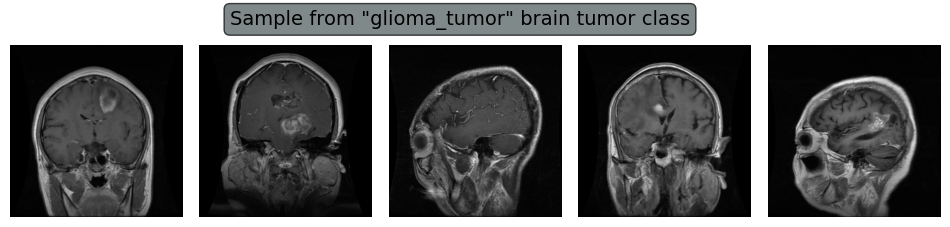

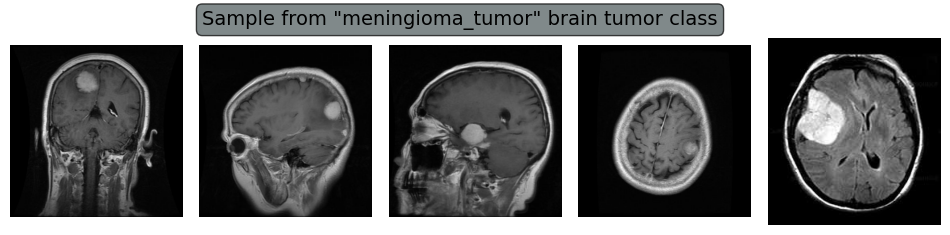

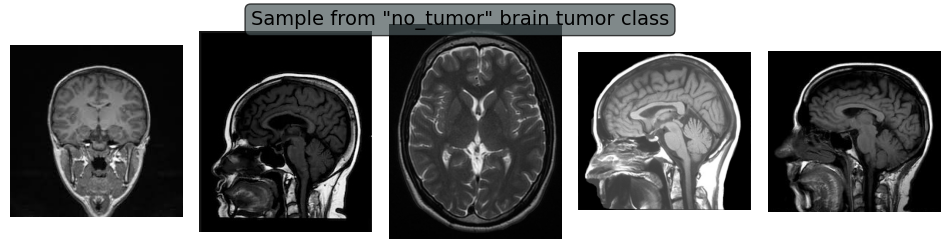

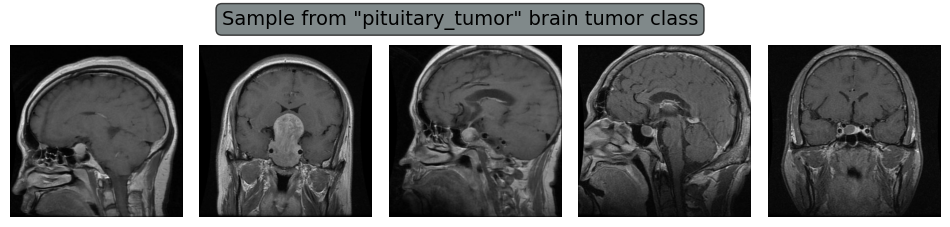

In [10]:
import random
import matplotlib.pyplot as plt
from PIL import Image
# Plotting random images of each file(class)

for brain_tumor_class in classes : # Loop through each class
    
    # Accessing images in files 
    class_dir = os.path.join(dataSetDir + '/Training' , brain_tumor_class) # The image path of the rice class
    images_path = os.listdir(class_dir) # List of images
    random_images = random.sample(images_path , k = 5) # Random sample of images
    
    # Plotting some sample images
    fig , ax = plt.subplots(1 , 5 , figsize = (12 , 3)) 
    plt.suptitle(f'Sample from "{brain_tumor_class}" brain tumor class', fontsize = 14 
                 , bbox=dict(facecolor='#4A5759', alpha=0.7 , boxstyle='round,pad=0.3') , y = 0.9) # Title for each sample
    
    for i , random_image in enumerate(random_images) : # Loop for each image
        image_path = os.path.join(class_dir , random_image) # Creating image path
        image = Image.open(image_path) # Load image
        
        ax[i].imshow(image) # Plot image
        ax[i].axis('off') # Remove the axis
    
    plt.subplots_adjust( hspace = -0.2 , wspace = 0.1 )
    plt.show()
    print('\n')

In [11]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
class brainTumorClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convolutionLayer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
         )

        self.fullyConnectedLayer = nn.Sequential(
            nn.Linear(in_features=35*35*128, out_features=1024),
            nn.ReLU(),
            nn.Linear(1024, 4),
        )
    def forward(self, x):
        convolutionOut = self.convolutionLayer(x)
        flatenedConOut = torch.flatten(convolutionOut,1)
        return self.fullyConnectedLayer(flatenedConOut)
    
model = brainTumorClassifier()
model.to(device=device)


brainTumorClassifier(
  (convolutionLayer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fullyConnectedLayer): Sequential(
    (0): Linear(in_features=156800, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=4, bias=True)
  )
)

In [13]:
from torchsummary import summary
summary(model, (3, 150, 150))


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 35, 35]         --
|    └─Conv2d: 2-1                       [-1, 32, 148, 148]        896
|    └─ReLU: 2-2                         [-1, 32, 148, 148]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 74, 74]          --
|    └─Conv2d: 2-4                       [-1, 64, 72, 72]          18,496
|    └─ReLU: 2-5                         [-1, 64, 72, 72]          --
|    └─Conv2d: 2-6                       [-1, 128, 70, 70]         73,856
|    └─ReLU: 2-7                         [-1, 128, 70, 70]         --
|    └─MaxPool2d: 2-8                    [-1, 128, 35, 35]         --
├─Sequential: 1-2                        [-1, 4]                   --
|    └─Linear: 2-9                       [-1, 1024]                160,564,224
|    └─ReLU: 2-10                        [-1, 1024]                --
|    └─Linear: 2-11                      [-1, 4]                   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 35, 35]         --
|    └─Conv2d: 2-1                       [-1, 32, 148, 148]        896
|    └─ReLU: 2-2                         [-1, 32, 148, 148]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 74, 74]          --
|    └─Conv2d: 2-4                       [-1, 64, 72, 72]          18,496
|    └─ReLU: 2-5                         [-1, 64, 72, 72]          --
|    └─Conv2d: 2-6                       [-1, 128, 70, 70]         73,856
|    └─ReLU: 2-7                         [-1, 128, 70, 70]         --
|    └─MaxPool2d: 2-8                    [-1, 128, 35, 35]         --
├─Sequential: 1-2                        [-1, 4]                   --
|    └─Linear: 2-9                       [-1, 1024]                160,564,224
|    └─ReLU: 2-10                        [-1, 1024]                --
|    └─Linear: 2-11                      [-1, 4]                   

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
n_epochs = 10


for epoch in range(n_epochs):
    train_loss = 0.0
    train_accuracy = 0
    model.train() 
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1, 
            train_loss
            ))
    print(f"Train accuracy: {train_accuracy/len(train_loader):.3f}")

Epoch: 1 	Training Loss: 0.858948
Train accuracy: 0.646
Epoch: 2 	Training Loss: 0.493096
Train accuracy: 0.798
Epoch: 3 	Training Loss: 0.297629
Train accuracy: 0.881
Epoch: 4 	Training Loss: 0.151707
Train accuracy: 0.945
Epoch: 5 	Training Loss: 0.100391
Train accuracy: 0.964
Epoch: 6 	Training Loss: 0.068808
Train accuracy: 0.978
Epoch: 7 	Training Loss: 0.069590
Train accuracy: 0.975
Epoch: 8 	Training Loss: 0.015127
Train accuracy: 0.995
Epoch: 9 	Training Loss: 0.021503
Train accuracy: 0.994
Epoch: 10 	Training Loss: 0.022570
Train accuracy: 0.992


In [16]:
test_accuracy = 0
model.eval()
for data, target in testLoader:
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    ps = torch.exp(output)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == target.view(*top_class.shape)
    test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {test_accuracy/len(testLoader):.3f}")


Test accuracy: 0.665
